<a href="https://colab.research.google.com/github/DhilipSanjay/Human-Biomechanic-Analysis/blob/main/Parkinson's_Disease_Physionet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Biomechanic Analysis

## Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from google.colab import drive

## Mount Drive & Load Dataset

In [ ]:
drive.mount('/content/drive')
dataset_dir = "/content/drive/MyDrive/College Related/Project Work 1 - Sem 7/Dataset/"
dataset_zip = dataset_dir + "gait-in-parkinsons-disease-1.0.0.zip"

!unzip -q "$dataset_zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Convert to CSV format

In [ ]:
!rm -r CSV
!rm -r Final

In [ ]:
!mv gait-in-parkinsons-disease-1.0.0 Physionet
len(os.listdir('Physionet'))

mv: cannot stat 'gait-in-parkinsons-disease-1.0.0': No such file or directory


313

In [ ]:
features = ['Time', 'L1' , 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 
            'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 
            'Total_Force_Left', 'Total_Force_Right']

In [ ]:
!mkdir CSV

# reading given csv file 
# and creating dataframe
for name in os.listdir('Physionet'):
  if 'Co' in name or 'Pt' in name:
    # print(name)
    df = pd.read_csv('Physionet/' + name, header = None, sep='\t')
      
    # adding column headings
    df.columns = features
      
    # store dataframe into csv file
    name = 'CSV/' + name.split('.')[0]+'.csv'
    # print(name)
    df.to_csv(name, index = None)

## Data Visualization

(1001, 19)
(1001, 19)


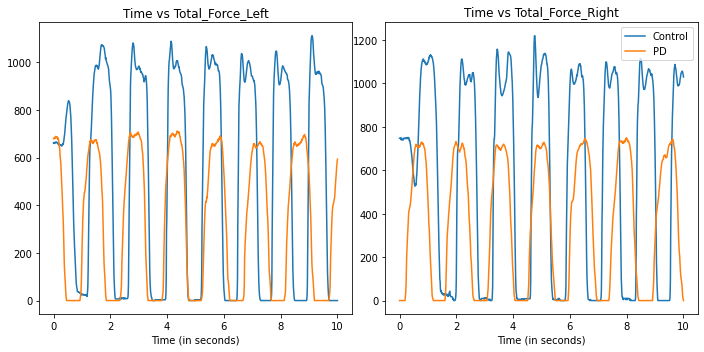

In [ ]:
pd_subject = 'GaPt03_01'
control_subject = 'GaCo01_01'

pd_df = pd.read_csv('CSV/' + pd_subject + '.csv').head(1001)
control_df = pd.read_csv('CSV/' + control_subject + '.csv').head(1001)
print(pd_df.shape)
print(control_df.shape)

nrows = 1
ncols = 2

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 5)

for i, fname in enumerate(['Total_Force_Left', 'Total_Force_Right']):
  plt.subplot(nrows, ncols, i+1)
  plt.tight_layout()
  plt.title("Time vs " + fname)
  plt.plot(control_df.Time, control_df[fname])
  plt.plot(pd_df.Time, pd_df[fname])
  plt.xlabel('Time (in seconds)')

plt.legend(["Control", "PD",]) 
plt.show()

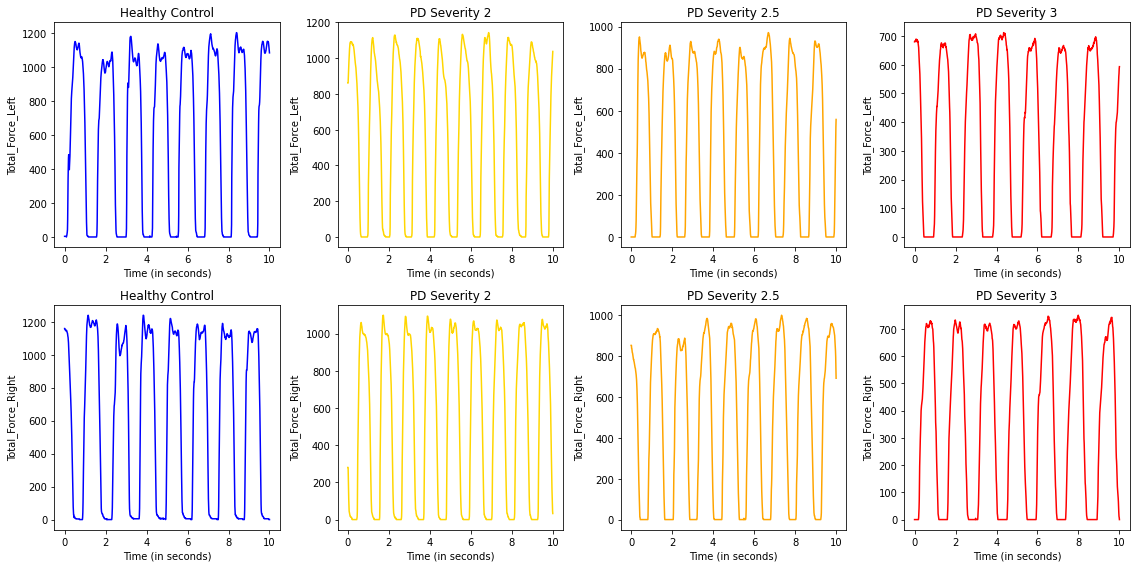

In [ ]:
nrows = 2
ncols = 4
subjects = ['GaCo03_01', 'GaPt06_01', 'GaPt04_01', 'GaPt03_01']
category = ['Healthy Control', 'PD Severity 2', 'PD Severity 2.5', 'PD Severity 3']
colors = ['blue', '#FFD600', 'orange', 'red']
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

i = 0
for sub in subjects:
  df = pd.read_csv('CSV/' + sub + '.csv').head(1001)
  i += 1
  for j, fname in enumerate(['Total_Force_Left', 'Total_Force_Right']):
    plt.subplot(nrows, ncols, i + (j*4))
    plt.tight_layout()
    plt.plot(df.Time, df[fname], color=colors[i-1])
    plt.xlabel('Time (in seconds)')
    plt.ylabel(fname)
    plt.title(category[i-1])
    
plt.show()

## Preprocess the dataset

### Demographics

In [ ]:
demographics = pd.read_csv('Physionet/demographics.txt', delim_whitespace=True)
sub_id = demographics.ID.to_list()
sub_names = []
for name in os.listdir('CSV'):
  sub_name = name.split('_')[0]
  sub_names.append(sub_name)

print("Subjects Count (in demographics) = ", len(sub_id))
print("Files count = ", len(sub_names))

Subjects Count (in demographics) =  166
Files count =  306


### Preprocessing HoehnYahr Feature
- Filling the missing data
- Changing the classes 

| HY Score | Class |
|----------|-------|
| 0.0 | 0 |
| 2.5 | 1 |
| 2.0 | 2 |
| 3.0 | 3 |

In [ ]:
demographics.HoehnYahr
demographics['HoehnYahr'] = demographics['HoehnYahr'].fillna(0)
demographics.HoehnYahr.value_counts()

0.0    73
2.0    55
2.5    28
3.0    10
Name: HoehnYahr, dtype: int64

In [ ]:
# Remove the demographics of missing file
demographics = demographics[demographics.ID != 'Juc010']
print("Subject Count from different Study")
print(demographics.Study.value_counts())

print("\nSubject Count - Study & Gender")
print(pd.crosstab(demographics.Study, demographics.Gender))

print("\nSubject Count - Study & Groups")
print(pd.crosstab(demographics.Study, demographics.Group))

print("\nSubject Count - Groups & Gender")
print(pd.crosstab(demographics.Group, demographics.Gender))

print("\nSubject Count - Study + Groups & Gender")
print(pd.crosstab([demographics.Study, demographics.Group], demographics.Gender))

print("\nSubject Count - Study Group & HoehnYahr Severity")
print(pd.crosstab(demographics.Study, demographics.HoehnYahr))

Subject Count from different Study
Si    64
Ju    54
Ga    47
Name: Study, dtype: int64

Subject Count - Study & Gender
Gender   1   2
Study         
Ga      30  17
Ju      28  26
Si      40  24

Subject Count - Study & Groups
Group   1   2
Study        
Ga     29  18
Ju     29  25
Si     35  29

Subject Count - Groups & Gender
Gender   1   2
Group         
1       58  35
2       40  32

Subject Count - Study + Groups & Gender
Gender        1   2
Study Group        
Ga    1      20   9
      2      10   8
Ju    1      16  13
      2      12  13
Si    1      22  13
      2      18  11

Subject Count - Study Group & HoehnYahr Severity
HoehnYahr  0.0  2.0  2.5  3.0
Study                        
Ga          18   15    8    6
Ju          25   12   13    4
Si          29   28    7    0


In [ ]:
demographics['HoehnYahr'].replace({2.5: 1}, inplace=True)
demographics['HoehnYahr'] = demographics['HoehnYahr'].astype(int)
demographics.HoehnYahr.value_counts()

0    72
2    55
1    28
3    10
Name: HoehnYahr, dtype: int64

## Segmentation of the Data
- Each segment will be of the shape 100 x 19

In [ ]:
!mkdir Final
!mkdir Final/train
!mkdir Final/test

count = len(os.listdir('CSV'))
train_count = int(70/100*count)
test_count = count - train_count

print("Training Count Subjects = ", train_count)
print("Test Count Subjects = ", test_count)

category = 'train'
counter = 1

ypath = 'Final/y_' + category + '.txt'
yfile = open(ypath, "a")
hypath = 'Final/hyscore_' + category + '.txt'
hyfile = open(hypath, "a")

for name in os.listdir('CSV'):
  if counter == train_count + 1:
    yfile.flush()
    yfile.close()
    hyfile.flush()
    hyfile.close()
    
    category = 'test'    
    ypath = 'Final/y_' + category + '.txt'
    yfile = open(ypath, "a")
    hypath = 'Final/hyscore_' + category + '.txt'
    hyfile = open(hypath, "a")
  print(counter, name, category)
  
  sub_name = name.split('_')[0]
  sub_class = demographics[demographics['ID'] == sub_name]['Group'].to_string(index=False).strip()
  hy_class = demographics[demographics['ID'] == sub_name]['HoehnYahr'].to_string(index=False).strip()
  sub_data = pd.read_csv('CSV/' + name)
  features = sub_data.columns.to_list()

  full_size = 100
  overlap = 0.5
  overlap_size = int(full_size * overlap / 2)
  entry_size = full_size - overlap_size
  
  for i in range(0, sub_data.shape[0], entry_size):
    if sub_data.shape[0] >= i + entry_size + overlap_size:
      yfile.write(sub_class + "\n")
      hyfile.write(hy_class + "\n")
      
      for fname in features:
        path_name = 'Final/' + category + '/'
        file_name = fname + '_' + category + '.txt'
        with open(path_name + file_name, 'a') as feat_file:
          arr = sub_data.iloc[i:i + entry_size + overlap_size, ][fname].to_numpy()
          # print(i, len(arr), end = ' | ')
          feat_file.write(' '.join(map(str, arr)) + "\n")

  counter = counter + 1
yfile.flush()
yfile.close()
hyfile.flush()
yfile.close()

Training Count Subjects =  214
Test Count Subjects =  92
1 GaCo14_01.csv train
2 GaCo06_01.csv train
3 JuPt03_01.csv train
4 JuCo23_01.csv train
5 JuPt23_02.csv train
6 GaPt05_01.csv train
7 JuPt20_04.csv train
8 SiCo20_01.csv train
9 JuPt11_07.csv train
10 JuPt10_06.csv train
11 JuPt20_05.csv train
12 GaPt25_10.csv train
13 JuPt25_01.csv train
14 GaPt31_02.csv train
15 JuCo03_01.csv train
16 JuCo21_01.csv train
17 SiPt12_01.csv train
18 SiCo06_01.csv train
19 JuPt28_04.csv train
20 JuPt03_03.csv train
21 SiCo03_01.csv train
22 SiPt39_01.csv train
23 SiCo01_01.csv train
24 JuPt03_05.csv train
25 JuCo24_01.csv train
26 SiCo09_01.csv train
27 GaPt06_01.csv train
28 GaCo05_01.csv train
29 JuPt20_01.csv train
30 GaPt23_10.csv train
31 SiPt27_01.csv train
32 JuPt28_01.csv train
33 JuCo14_01.csv train
34 GaCo12_01.csv train
35 JuPt01_04.csv train
36 JuPt21_07.csv train
37 GaPt13_02.csv train
38 GaPt29_02.csv train
39 GaCo07_02.csv train
40 GaCo17_01.csv train
41 GaPt27_02.csv train
42 JuPt15

## Load Dataset - Training and Testing

In [ ]:
def load_file(filepath):
	dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files into a 3D array of [samples, timesteps, features]
def load_category(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded


# load a dataset category, such as train or test
def load_dataset_category(category, prefix=''):
	# load all 19 files as a single array
	filenames = []
	for fname in features:
		filenames.append(category + '/' + fname + '_' + category + '.txt')
  
	# load input data
	X = load_category(filenames, prefix)
	# load class output
	y = load_file(prefix + 'y_'+ category +'.txt')
	hy = load_file(prefix + 'hyscore_'+ category +'.txt')
	return X, y, hy

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy, trainHY = load_dataset_category('train', prefix)
	print(trainX.shape, trainy.shape, trainHY.shape)
	# load all test
	testX, testy, testHY = load_dataset_category('test', prefix)
	print(testX.shape, testy.shape, testHY.shape)
 
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = tf.keras.utils.to_categorical(trainy)
	trainHY = tf.keras.utils.to_categorical(trainHY)
	testy = tf.keras.utils.to_categorical(testy)
	testHY = tf.keras.utils.to_categorical(testHY)  
 
	# print(trainX.shape, trainy.shape, trainHY.shape, testX.shape, testy.shape, testHY.shape)
	return trainX, trainy, trainHY, testX, testy, testHY

In [ ]:
trainX, trainy, trainHY, testX, testy, testHY = load_dataset('Final/')
print("Training Data = ", trainX.shape)
print("Training Class = ", trainy.shape)
print("Training HoehnYahr Class = ", trainHY.shape)
print("Test Data = ", testX.shape)
print("Test Class = ", testy.shape)
print("Test HoehnYahr Class = ", testHY.shape)

(30729, 100, 19) (30729, 1) (30729, 1)
(13297, 100, 19) (13297, 1) (13297, 1)
Training Data =  (30729, 100, 19)
Training Class =  (30729, 2)
Training HoehnYahr Class =  (30729, 4)
Test Data =  (13297, 100, 19)
Test Class =  (13297, 2)
Test HoehnYahr Class =  (13297, 4)


## Detection of PD
- PD - 0
- Control - 1

### PD Model

In [ ]:
verbose, epochs, batch_size = 1, 500, 32
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

DESIRED_ACCURACY = 0.97

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached " + str(DESIRED_ACCURACY*100)  + "% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics =[tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'),
                        'accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 98, 64)            3712      
                                                                 
 conv1d_23 (Conv1D)          (None, 96, 64)            12352     
                                                                 
 dropout_11 (Dropout)        (None, 96, 64)            0         
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 48, 64)           0         
 g1D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 3072)              0         
                                                                 
 dense_22 (Dense)            (None, 100)               307300    
                                                     

### Train the model

In [ ]:
with tf.device('/device:GPU:0'):
  PD_history = model.fit(trainX,
                        trainy,
                        validation_data=(testX, testy),
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = verbose,
                        callbacks = [callbacks])

Epoch 1/500
961/961 [==============================] - 18s 16ms/step - loss: 1.4790 - tp: 23979.0000 - fp: 6750.0000 - tn: 23979.0000 - fn: 6750.0000 - accuracy: 0.7803 - precision: 0.7803 - recall: 0.7803 - auc: 0.8458 - val_loss: 0.5998 - val_tp: 9969.0000 - val_fp: 3328.0000 - val_tn: 9969.0000 - val_fn: 3328.0000 - val_accuracy: 0.7497 - val_precision: 0.7497 - val_recall: 0.7497 - val_auc: 0.7883
Epoch 2/500
961/961 [==============================] - 14s 15ms/step - loss: 0.3438 - tp: 26513.0000 - fp: 4216.0000 - tn: 26513.0000 - fn: 4216.0000 - accuracy: 0.8628 - precision: 0.8628 - recall: 0.8628 - auc: 0.9279 - val_loss: 0.6580 - val_tp: 9628.0000 - val_fp: 3669.0000 - val_tn: 9628.0000 - val_fn: 3669.0000 - val_accuracy: 0.7241 - val_precision: 0.7241 - val_recall: 0.7241 - val_auc: 0.7573
Epoch 3/500
961/961 [==============================] - 15s 15ms/step - loss: 0.2646 - tp: 27596.0000 - fp: 3133.0000 - tn: 27596.0000 - fn: 3133.0000 - accuracy: 0.8980 - precision: 0.8980 -

### Save the Model

In [ ]:
model.save("/content/drive/MyDrive/College Related/Project Work 1 - Sem 7/Saved Models/PD_Model.h5")
print("PD_Model saved Successfully!")

PD_Model saved Successfully!


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/College Related/Project Work 1 - Sem 7/Saved Models/PD_Model.h5")

### Plot the graphs

In [ ]:
# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title('Training and Validation ' + string)
  plt.show()

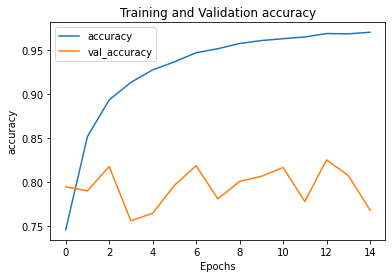

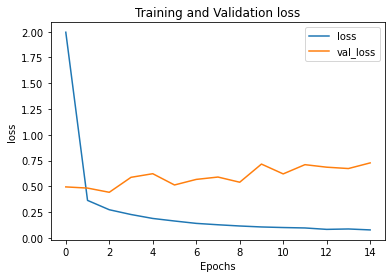

In [ ]:
plot_graphs(PD_history, "accuracy")
plot_graphs(PD_history, "loss")

### Evaluation of Model

In [ ]:
def model_evaluate(model, target, testX, testy):
  y_pred = model.predict(testX)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(testy, axis=1)

  # Confusion matrix
  print('Confusion Matrix')

  cm = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)
  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = accuracy_score(y_test, y_pred) * 100
  print("Accuracy for Test Data = ", conf_acc)

  plt.figure(figsize = (12,8))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  # Classification Report
  print('\nClassification Report')
  print(classification_report(y_test, y_pred))

  # Cohen Kappa Score
  print('\nCohen Kappa Score')
  print(cohen_kappa_score(y_test, y_pred))

  # Precision vs Recall Curve
  print('\nPrecision vs Recall Curve')
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

  y_test = tf.keras.utils.to_categorical(y_test)
  y_pred = tf.keras.utils.to_categorical(y_pred)
  n_classes = 2

  precision = dict()
  recall = dict()

  for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                          y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
      
  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.legend(loc="best")
  plt.title("Precision vs. Recall curve")
  plt.show()

  # ROC Curve
  print('\nROC Curve')
  average = 'macro'
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
  for (idx, c_label) in enumerate(target):
      fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
      c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  print('ROC AUC score:', roc_auc_score(y_test, y_pred, average=average))

  c_ax.legend()
  c_ax.set_xlabel('False Positive Rate')
  c_ax.set_ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

Confusion Matrix
Accuracy for Test Data =  94.12649469805218


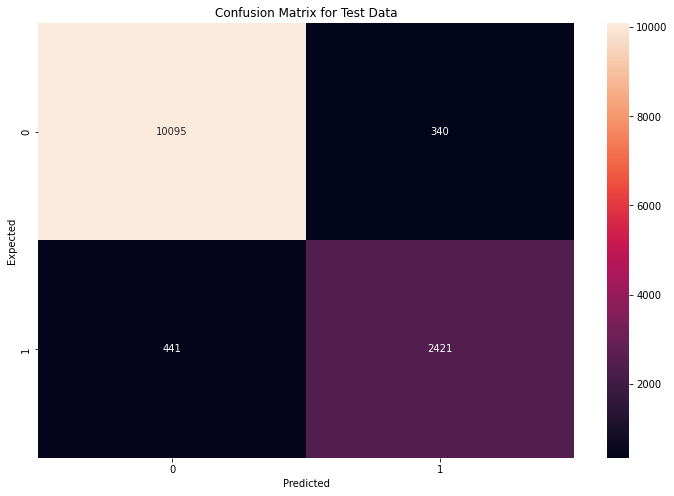


Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     10435
           1       0.88      0.85      0.86      2862

    accuracy                           0.94     13297
   macro avg       0.92      0.91      0.91     13297
weighted avg       0.94      0.94      0.94     13297


Cohen Kappa Score
0.8238795014003799

Precision vs Recall Curve


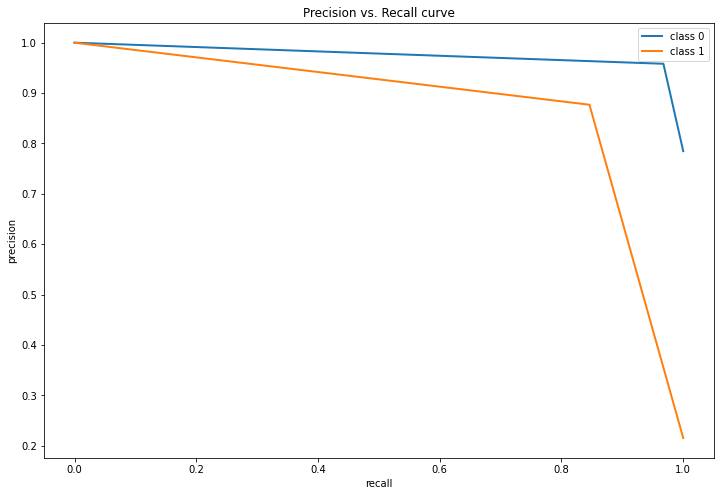


ROC Curve
ROC AUC score: 0.906664647578752


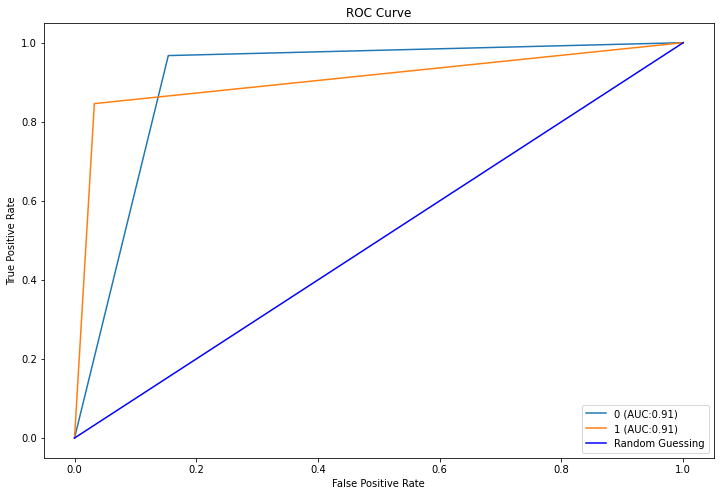

In [ ]:
model_evaluate(model, [0,1], testX, testy)

## Classification based on HoehnYahr Score

### HY Model

In [ ]:
verbose, epochs, batch_size = 1, 500, 32
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainHY.shape[1]

callbacks = myCallback()
HYmodel = tf.keras.models.Sequential()
HYmodel.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
HYmodel.add(tf.keras.layers.MaxPooling1D(pool_size=2))
HYmodel.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
HYmodel.add(tf.keras.layers.MaxPooling1D(pool_size=2))
HYmodel.add(tf.keras.layers.Dropout(0.5))
HYmodel.add(tf.keras.layers.Flatten())
HYmodel.add(tf.keras.layers.Dense(100, activation='relu'))
HYmodel.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))

HYmodel.compile(loss = 'categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics =[tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'),
                        'accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')])
HYmodel.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 98, 64)            3712      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 49, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 47, 64)            12352     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 23, 64)           0         
 g1D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 23, 64)            0         
                                                                 
 flatten_9 (Flatten)         (None, 1472)             

### Train the model

In [ ]:
with tf.device('/device:GPU:0'):
  HY_history = HYmodel.fit(trainX,
                          trainHY,
                          validation_data=(testX, testHY),
                          epochs = epochs, 
                          batch_size = batch_size, 
                          verbose = verbose,
                          callbacks = [callbacks])

Epoch 1/500
961/961 [==============================] - 18s 16ms/step - loss: 15.2232 - tp: 8588.0000 - fp: 18713.0000 - tn: 73474.0000 - fn: 22141.0000 - accuracy: 0.3126 - precision: 0.3146 - recall: 0.2795 - auc: 0.5614 - val_loss: 1.3759 - val_tp: 13.0000 - val_fp: 42.0000 - val_tn: 39849.0000 - val_fn: 13284.0000 - val_accuracy: 0.2290 - val_precision: 0.2364 - val_recall: 9.7766e-04 - val_auc: 0.5306
Epoch 2/500
961/961 [==============================] - 14s 15ms/step - loss: 1.4522 - tp: 1798.0000 - fp: 3295.0000 - tn: 88892.0000 - fn: 28931.0000 - accuracy: 0.3304 - precision: 0.3530 - recall: 0.0585 - auc: 0.6024 - val_loss: 1.3398 - val_tp: 6.0000 - val_fp: 1.0000 - val_tn: 39890.0000 - val_fn: 13291.0000 - val_accuracy: 0.2166 - val_precision: 0.8571 - val_recall: 4.5123e-04 - val_auc: 0.5909
Epoch 3/500
961/961 [==============================] - 14s 15ms/step - loss: 1.3195 - tp: 755.0000 - fp: 1066.0000 - tn: 91121.0000 - fn: 29974.0000 - accuracy: 0.3420 - precision: 0.414

### Save the model

In [ ]:
HYmodel.save("/content/drive/MyDrive/College Related/Project Work 1 - Sem 7/Saved Models/HY_Model.h5")
print("HY_Model saved Successfully!")

HY_Model saved Successfully!


In [ ]:
HYmodel = tf.keras.models.load_model("/content/drive/MyDrive/College Related/Project Work 1 - Sem 7/Saved Models/HY_Model.h5")

### Plot the graphs

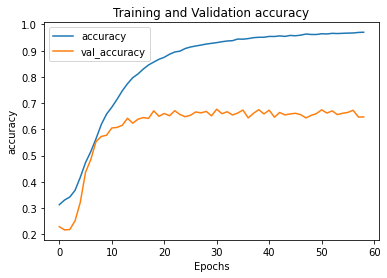

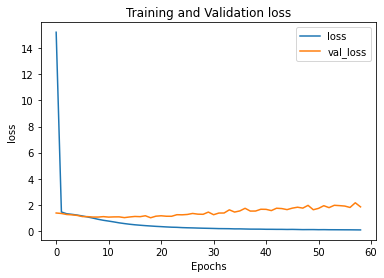

In [ ]:
plot_graphs(HY_history, "accuracy")
plot_graphs(HY_history, "loss")

### Evaluation of Model

Confusion Matrix
Accuracy for Test Data =  89.67436263818907


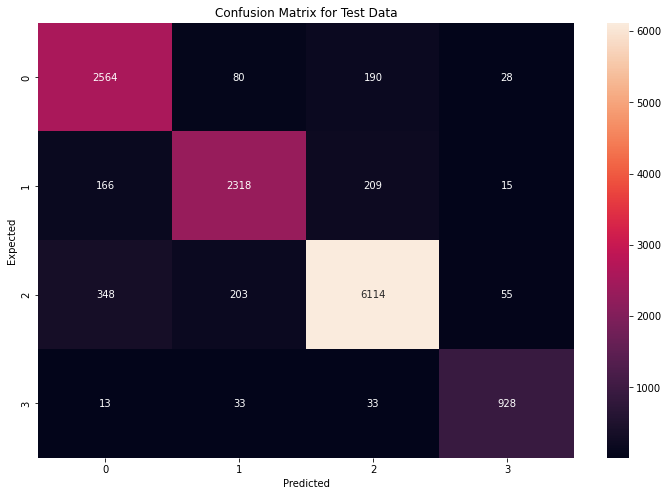


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2862
           1       0.88      0.86      0.87      2708
           2       0.93      0.91      0.92      6720
           3       0.90      0.92      0.91      1007

    accuracy                           0.90     13297
   macro avg       0.89      0.90      0.89     13297
weighted avg       0.90      0.90      0.90     13297


Cohen Kappa Score
0.8423538312049089

Precision vs Recall Curve


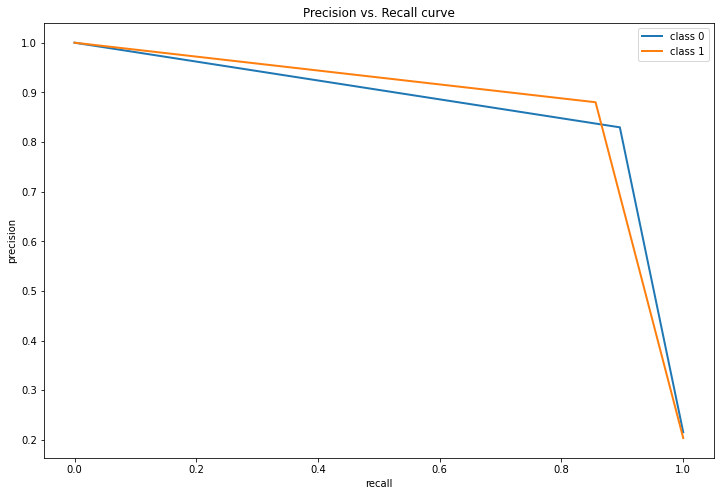


ROC Curve
ROC AUC score: 0.9286533824686953


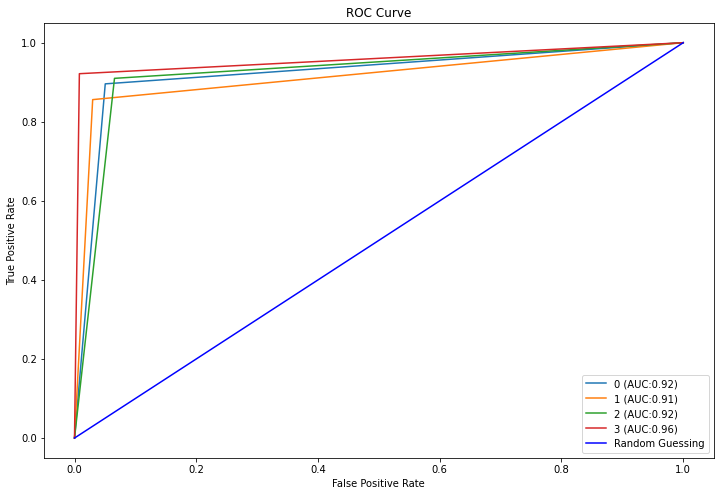

In [ ]:
model_evaluate(HYmodel, [0, 1, 2, 3], testX, testHY)